# Project : Stock Price Predictions & Forecasting with LSTM Neural Networks

## Section 1 : Importation 

In [36]:
import pandas as pd 
import datetime 
import matplotlib.pyplot as plt 
import numpy as np 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layer
from copy import deepcopy

In [2]:
path = "data/historical_data.csv"
df = pd.read_csv(path)
df

,Date,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Volume
0,2005-01-03,18.635152,18.739454,18.530851,18.593431,65002900
1,2005-01-04,18.683830,18.843759,18.537808,18.662970,109442100
2,2005-01-05,18.662963,18.843752,18.607335,18.621243,72463500
3,2005-01-06,18.669918,18.815939,18.523896,18.600384,76890500
4,2005-01-07,18.649061,18.697734,18.509993,18.544760,68723300
...,...,...,...,...,...,...
5026,2024-12-20,433.109985,443.739990,428.630005,436.600006,64263700
5027,2024-12-23,436.739990,437.649994,432.829987,435.250000,19152500
5028,2024-12-24,434.649994,439.600006,434.190002,439.329987,7164500
5029,2024-12-26,439.079987,440.940002,436.630005,438.109985,8194200


In [3]:
df = df[['Date', 'MSFT_Close']]

df

,Date,MSFT_Close
0,2005-01-03,18.593431
1,2005-01-04,18.662970
2,2005-01-05,18.621243
3,2005-01-06,18.600384
4,2005-01-07,18.544760
...,...,...
5026,2024-12-20,436.600006
5027,2024-12-23,435.250000
5028,2024-12-24,439.329987
5029,2024-12-26,438.109985


In [4]:
#fonction : change str en datetime 
def str_to_datetime(str):
    split = str.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year = year, month=month, day=day)

In [5]:
df['Date'] = df['Date'].apply(str_to_datetime)

/var/folders/9j/rrq91tfd5kb0ycf73_xht2x80000gn/T/ipykernel_38785/3172778012.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


In [6]:
df['Date']

0      2005-01-03
1      2005-01-04
2      2005-01-05
3      2005-01-06
4      2005-01-07
          ...    
5026   2024-12-20
5027   2024-12-23
5028   2024-12-24
5029   2024-12-26
5030   2024-12-27
Name: Date, Length: 5031, dtype: datetime64[ns]

In [7]:
#on utilise Date comme index pour notre dataframe 
df.index = df.pop('Date')

In [9]:
#affichage 
df.head()

,MSFT_Close
Date,
2005-01-03,18.593431
2005-01-04,18.662970
2005-01-05,18.621243
2005-01-06,18.600384
2005-01-07,18.544760


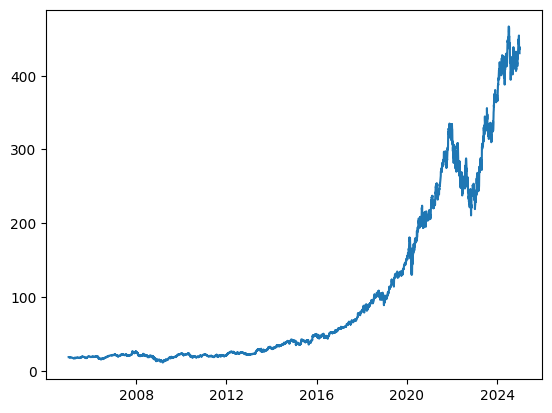

In [14]:
plt.plot(df.index, df['MSFT_Close'])

In [21]:
print(df.head(10))

            MSFT_Close
Date                  
2005-01-03   18.593431
2005-01-04   18.662970
2005-01-05   18.621243
2005-01-06   18.600384
2005-01-07   18.544760
2005-01-10   18.635155
2005-01-11   18.586481
2005-01-12   18.621243
2005-01-13   18.266624
2005-01-14   18.162327


In [60]:
#fonction : met en Y les prix des 3 dernier jour et en X la valeurs correspond a la dates 
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['MSFT_Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2023-04-01', 
                                '2024-12-20', 
                                n=3)
print(windowed_df)

    Target Date    Target-3    Target-2    Target-1      Target
0    2023-04-01  272.007751  277.225922  280.724457  284.924652
1    2023-04-04  280.724457  284.924652  283.867218  283.817780
2    2023-04-05  284.924652  283.867218  283.817780  281.011017
3    2023-04-06  283.867218  283.817780  281.011017  288.186005
4    2023-04-10  283.817780  281.011017  288.186005  286.001953
..          ...         ...         ...         ...         ...
429  2024-12-16  448.989990  449.559998  447.269989  451.589996
430  2024-12-17  449.559998  447.269989  451.589996  454.459991
431  2024-12-18  447.269989  451.589996  454.459991  437.390015
432  2024-12-19  451.589996  454.459991  437.390015  437.029999
433  2024-12-20  454.459991  437.390015  437.029999  436.600006

[434 rows x 5 columns]


In [61]:
def windowed_df_to_date_Xy(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
    Y = df_as_np[:, -1]
    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_Xy(windowed_df)

dates.shape, X.shape, y.shape

((434,), (434, 3, 1), (434,))

### Split the data into training and testing 

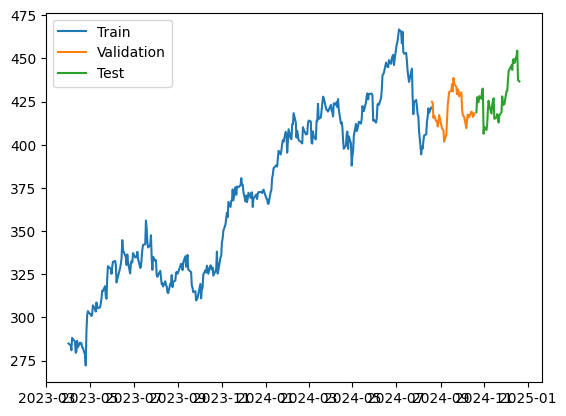

In [62]:
q_80 = int(len(dates) * .8) #80% of our data 
q_90 = int(len(dates) * .9) #90% of our data

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80] #train btw 0 & 80

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90] #val btw 80 & 90 
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:] #test btw 90 & 100 s

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

### Model of our ML 

In [63]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64), #number of neurones bigger the number
                    layers.Dense(32, activation='relu'), 
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)]) # on sort seulement un valeurs 

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 139360.2969 - mean_absolute_error: 370.1528 - val_loss: 175261.4688 - val_mean_absolute_error: 418.5475
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137982.1562 - mean_absolute_error: 368.3166 - val_loss: 174223.9062 - val_mean_absolute_error: 417.3062
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 138742.2500 - mean_absolute_error: 369.1887 - val_loss: 172498.8594 - val_mean_absolute_error: 415.2341
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 135467.4688 - mean_absolute_error: 364.9923 - val_loss: 170117.9219 - val_mean_absolute_error: 412.3572
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133392.1250 - mean_absolute_error: 361.9572 - val_loss: 165570.5156 - val_mean_absolute_error: 406.8058
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127715.7266 - mean_absolute_error: 354.1490 - val_loss: 159415.8125 - val_mean_absolute_error: 399.1695
Epoch 7/100
11/11 ━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


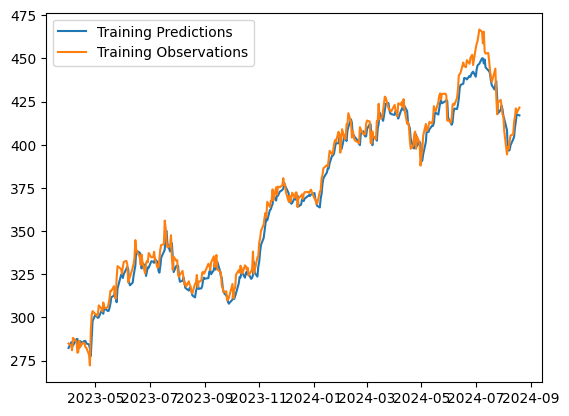

In [64]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


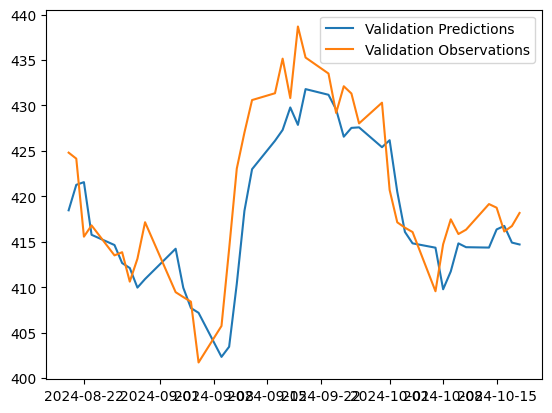

In [65]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


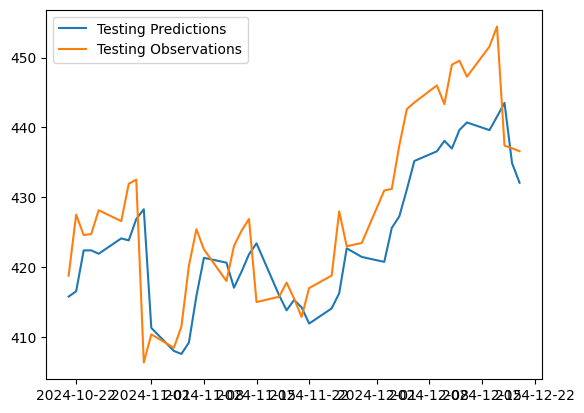

In [66]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [67]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

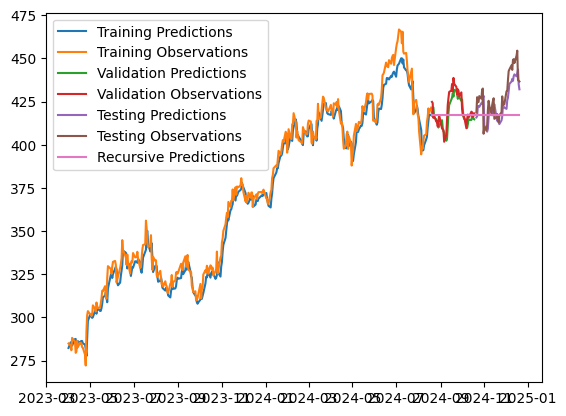

In [68]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])